In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from dataset.celeb_dataset import CelebDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import Subset
import os
from tqdm import tqdm
import wandb
from datetime import datetime
import torch.distributed as dist
from torch.nn.parallel.distributed import DistributedDataParallel as DDP
import socket
from mpi4py import MPI
import pickle
from collections import OrderedDict
import numpy as np

In [3]:
condition_config = {'task_name': 'celeba_attribute_classifier_resnet50_19_attributes',
                'condition_types': [ 'attribute' ],
                'attribute_condition_config': {
                    'attribute_condition_num': 1,
                    'attribute_condition_selected_attrs': ['Eyeglasses',]# 'Heavy_Makeup', 'Smiling'],
                    }
                }

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)



# Modify the fully connected layer to output 40 classes (for CelebA attributes)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, condition_config['attribute_condition_config']['attribute_condition_num'])

# Freeze all layers except the last 4 layers
for name, param in model.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False

classifier_state_dict = torch.load('celeba_resnet50_glasses_classifier.pth')

new_state_dict = OrderedDict()
for k, v in classifier_state_dict.items():
    if k.startswith('module.'):
        name = k[7:] # remove `module.`
    new_state_dict[name] = v

classifier_state_dict = new_state_dict

# load the model
model.load_state_dict(classifier_state_dict)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

/home/mate/miniconda3/envs/stable_diffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mate/miniconda3/envs/stable_diffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
data_dir = 'data/CelebAMask-HQ/'

im_dataset = CelebDataset(split='test',
                            im_path=data_dir,
                            im_size=256,
                            im_channels=3,
                            condition_config=condition_config,
                            classification=True)

100%|██████████| 30000/30000 [00:00<00:00, 70784.01it/s]

Found 30000 images
Found 0 masks
Found 0 captions
Found 30000 attributes


In [5]:
# print labels for the first image
print(im_dataset[0][1])

{'attribute': array([0])}


In [6]:
loader = DataLoader(im_dataset, batch_size=1, shuffle=False, num_workers=4)

In [7]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


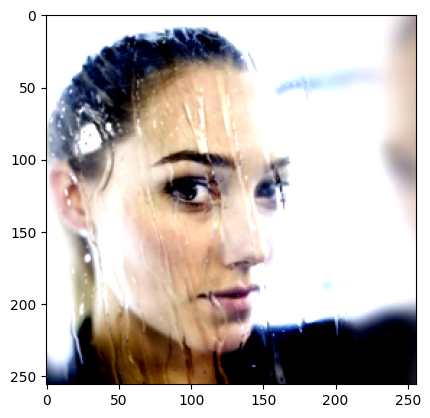

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.6648]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


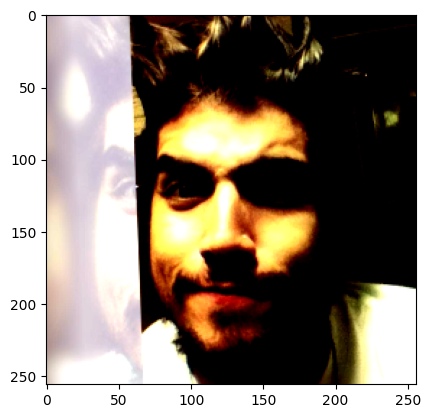

label: tensor([[1]], device='cuda:0')
prediction: tensor([[0.0065]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


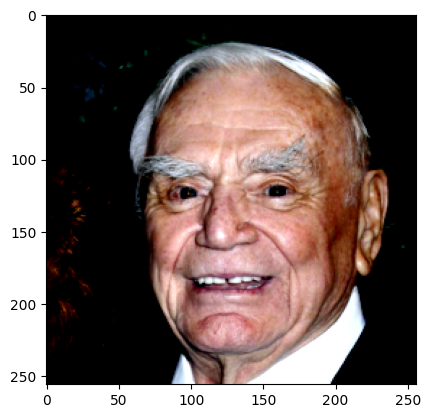

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: tensor([[1]], device='cuda:0')
prediction: tensor([[0.0040]], device='cuda:0')


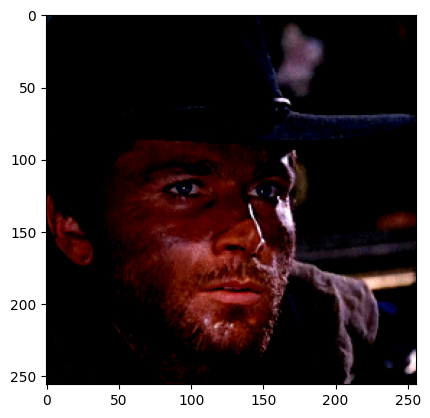

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.7013]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


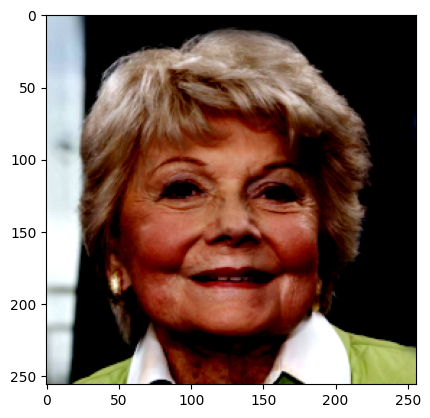

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.8386]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


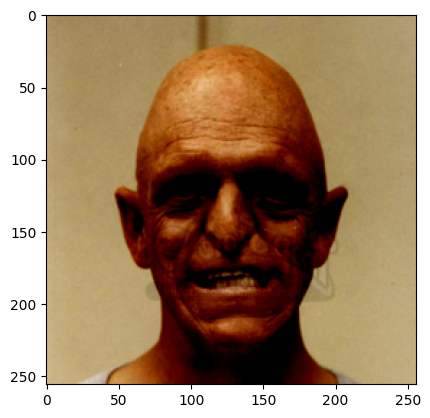

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.9919]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


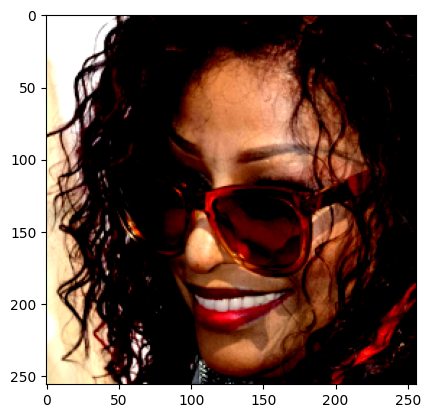

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.9993]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


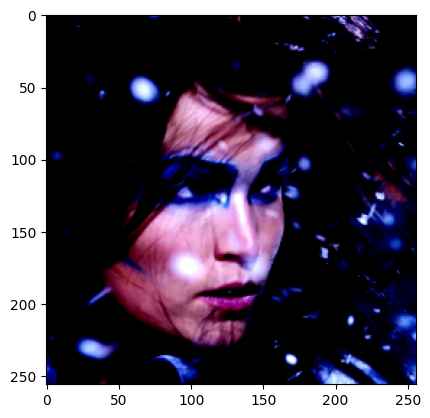

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.7226]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


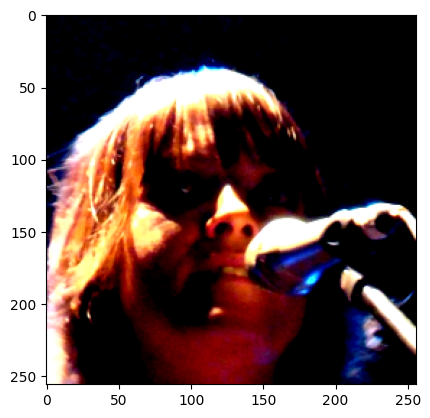

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.8408]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


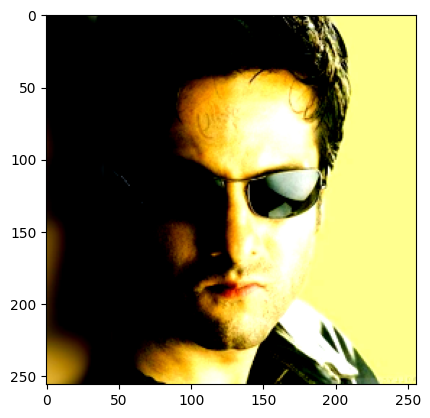

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.9936]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


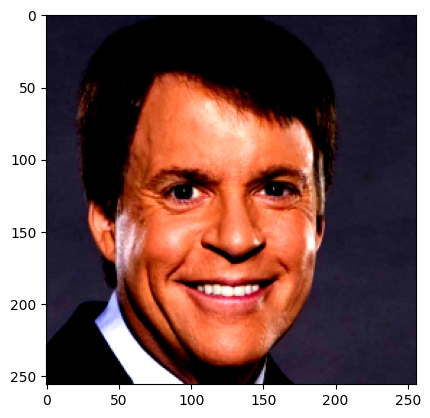

label: tensor([[1]], device='cuda:0')
prediction: tensor([[0.0046]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


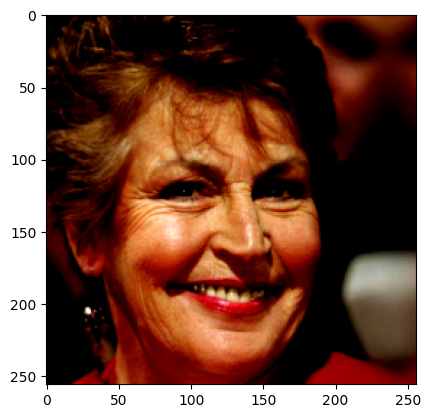

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.8308]], device='cuda:0')


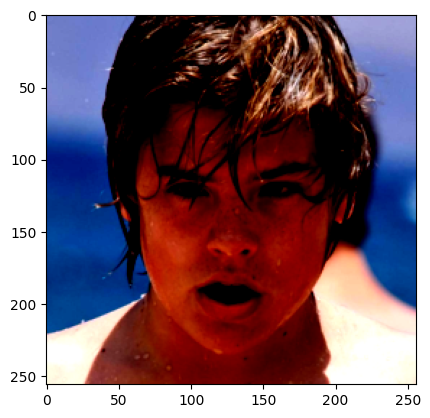

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.5172]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


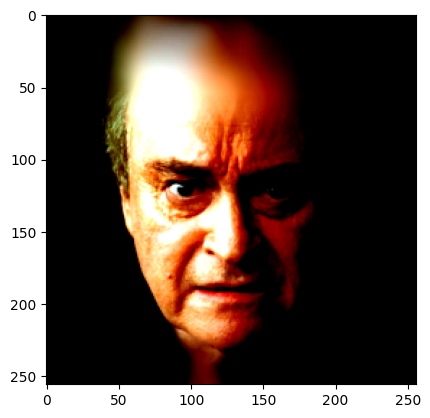

label: tensor([[1]], device='cuda:0')
prediction: tensor([[0.0065]], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


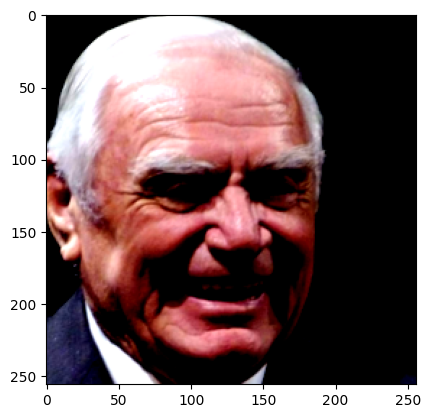

label: tensor([[0]], device='cuda:0')
prediction: tensor([[0.9824]], device='cuda:0')


In [8]:
# go through the dataset and get the predictions
predictions = []
labels = []

for i, (im, label) in enumerate(loader):
    im = im.to(device)
    label = label['attribute'].to(device)
    with torch.no_grad():
        output = model(im)
        output = torch.sigmoid(output)
        predictions.append(output.cpu().numpy())
        labels.append(label.cpu().numpy())

        # plot image that is missclassified
        if np.round(output.cpu().numpy()) != label.cpu().numpy():
            # denormalize image torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            im = im * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            plt.imshow(im[0].permute(1, 2, 0).cpu().numpy())
            plt.show()

            print('label:', label)
            print('prediction:', output)

        

In [9]:
predictions

[array([[0.00013532]], dtype=float32),
 array([[0.00067017]], dtype=float32),
 array([[0.00355861]], dtype=float32),
 array([[0.00231957]], dtype=float32),
 array([[0.00099583]], dtype=float32),
 array([[0.9936486]], dtype=float32),
 array([[0.0007729]], dtype=float32),
 array([[0.00520431]], dtype=float32),
 array([[0.00069827]], dtype=float32),
 array([[0.00075308]], dtype=float32),
 array([[0.00653264]], dtype=float32),
 array([[0.0013522]], dtype=float32),
 array([[0.00072904]], dtype=float32),
 array([[0.26558053]], dtype=float32),
 array([[0.00313867]], dtype=float32),
 array([[0.000374]], dtype=float32),
 array([[0.00164062]], dtype=float32),
 array([[0.00162883]], dtype=float32),
 array([[0.00044327]], dtype=float32),
 array([[0.45727903]], dtype=float32),
 array([[0.00079467]], dtype=float32),
 array([[0.00089364]], dtype=float32),
 array([[0.00357066]], dtype=float32),
 array([[0.00055147]], dtype=float32),
 array([[0.00217723]], dtype=float32),
 array([[0.00362364]], dtype=f

In [10]:
# round the predictions to 0 or 1
predictions_rounded = [np.round(p) for p in predictions]


In [11]:
# calculate the tp, fp, tn, fn
tp = 0
fp = 0
tn = 0
fn = 0

for i in range(len(predictions_rounded)):
    if predictions_rounded[i] == labels[i]:
        if predictions_rounded[i] == 1:
            tp += 1
        else:
            tn += 1
    else:
        if predictions_rounded[i] == 1:
            fp += 1
        else:
            fn += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)


In [12]:
labels = [l[0] for l in labels]
predictions_rounded = [p[0] for p in predictions_rounded]

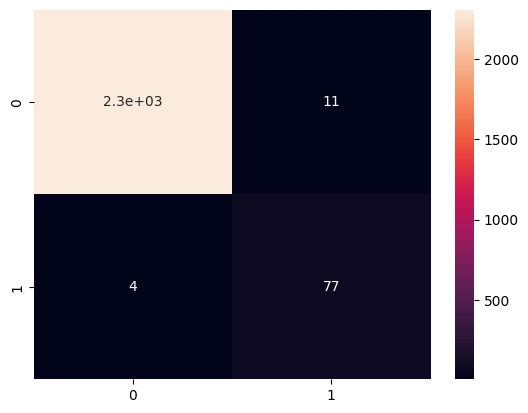

In [13]:
# visualize the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions_rounded)
sns.heatmap(cm, annot=True)
plt.show()


In [14]:
print('precision:', precision)
print('recall:', recall)
print('f1:', f1)


precision: 0.875
recall: 0.9506172839506173
f1: 0.9112426035502958
